# 位置敏感哈希的碰撞概率

我们使用上下文敏感的哈希在降低数据的维数时判断数据的相似程度，本文将就其中的碰撞概率做深入的探讨。

降低数据维数有若干储存和计算方面的好处。这里不再赘述。

## 前言

### [通用哈希](https://en.wikipedia.org/wiki/Universal_hashing)

思路是随机选择若干能保留数据需要的特征的哈希方程组合起来，这样可以保证对任何数据都有较好的效果（否则可以找到针对单一哈希函数的特殊数据使得该函数表现不佳）

### [位置敏感的哈希](https://en.wikipedia.org/wiki/Locality-sensitive_hashing)

我们有理由相信，在原向量空间中有一定位置关系的两点，在通过哈希函数映射以后位置依然保持该位置关系（参见[Slaney2008-LSHTutorial](http://www.slaney.org/malcolm/yahoo/Slaney2008-LSHTutorial.pdf))，那么自然我们可以用上面的通用哈希的思想选用多个具有位置关系的哈希的组合来判断是否相似。

举例来说，使用汉明距离的位抽样，抽样是取一定距离倍数的两点，汉明距离则是计算差异的方法（不同的个数），简化无关排列则是使用连续的数据组合来保留位置关系，也叫MinHash，也就是我们今天讨论的主要内容。


## MinHash

![A picture of the overview](https://i.stack.imgur.com/HYPWE.png)

1. Shingles : k-shingle（k-gram）取连续k个连续出现的元素，此时可以进行压缩（比如元素组合变成数字），压缩后得到的数据已经可以初步使用Jaccard方法进行相似性判断。

2. MinHashing : 每个哈希函数得到一个值，值组合成唯一的签名字段。大大压缩大小。此时我们希望相似性尽可能的被保持下来（当然会丢失）

3. Boosting : 此时只需要对签名字段继续比较就可以判断相似性。在一般情况下我们会多次形成key也就是会有多个哈希表，此时可以多个表中只要有一个相似就认为相似，或者全部相似时才认为相似（可能会比较难)（上示意图上再次使用LSH也许是指形成的多个表的也可以使用位置关系）


## 最终的判断函数

欸那我们总结一下上面的讨论结果，我们的到的方法是，对于一个对象，首先分解为有一定位置关系的子对象的组合来降维减少大小，然后使用多个哈希函数得到保留该对象特征的签名，为了增大匹配概率，我们重复这个过程得到若干表格，这样只要有一个表格中判断相似我们就认为相似，此时相似是（原相似程度/单个签名哈希函数个数/表格数目）的函数。

接下来我们就将对这个函数做具体的讨论和探究

经过分析我们可以得到该函数为
$$
f_{r, b}(t) = 1 - (1-t^r)^b
$$

其中，t是原相似程度，r是单个签名的哈希函数个数，b是重复产生的表格个数

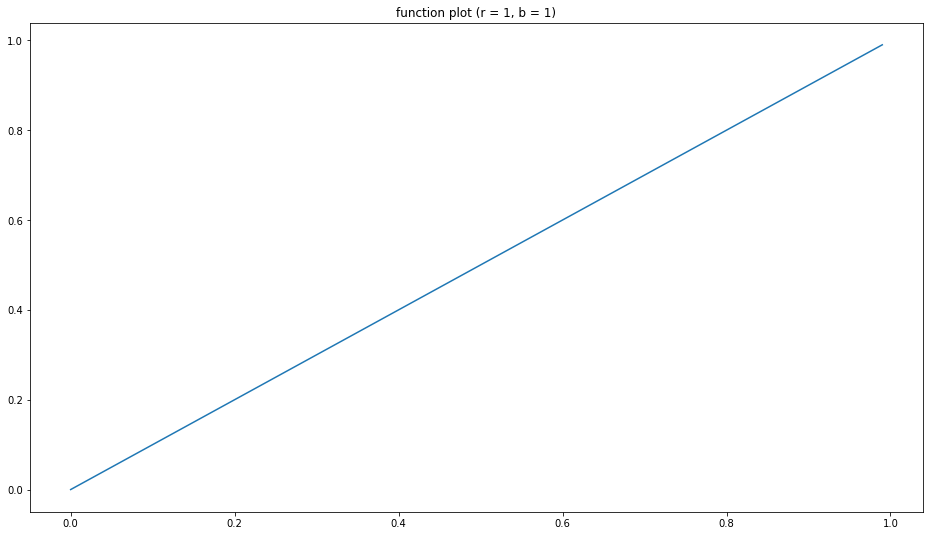

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f(t, b, r):
    return 1 - ( 1 - t ** r) ** b

xvals = np.arange(0, 1, 0.01)
yvals = np.array([f(x, 1, 1) for x in xvals])
plt.figure(figsize=(16,9))
plt.plot(xvals, yvals)
plt.title("function plot (r = 1, b = 1)")

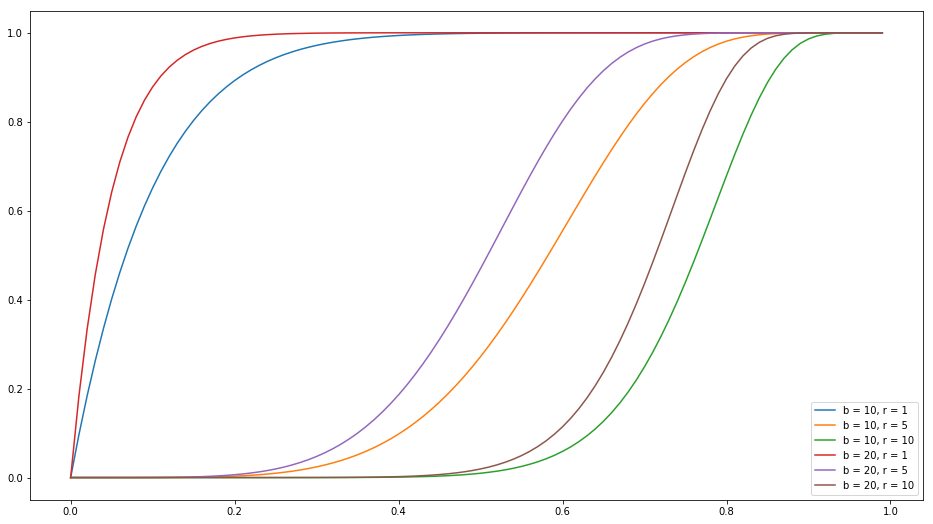

In [2]:
def func_plot(barray, rarray):
    plt.figure(figsize=(16,9))
    for b in barray:
        for r in rarray:
            xvals = np.arange(0, 1, 0.01)
            yvals = np.array([f(x, b, r) for x in xvals])
            plt.plot(xvals, yvals, label='b = {}, r = {}'.format(b, r))
    plt.legend()
            

func_plot([10, 20], [1, 5, 10])

## 结论

我们需要在一定原相似度附近突变的映射函数，大概重复的哈希表格越多，越容易被判断为相似，签名所需要的哈希函数越多，越不容易被判断为相似。